<a href="https://colab.research.google.com/github/Pumafi/dl_spatial_gen_geol_facies/blob/main/fast_stationary_ddim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch


## Setup

In [2]:
# From the git
import sys
sys.path.append('.')

In [3]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from data.load_data import load_data
from utils.visualisation import get_color_map
import tensorflow_addons as tfa

from tensorflow import keras
from keras import layers

import numpy as np

2023-11-16 11:03:51.734768: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/fbhavsar/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/fbhavsar/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow ve

In [4]:
import scipy

In [226]:
def schedule_function(t, max_t, epsilon=1e-3):
    f_t = tf.math.cos(((t/max_t) + epsilon) / (1+epsilon) * (np.pi/2))**2
    f_0 = tf.math.cos(((t*0/max_t) + epsilon) / (1+epsilon) * (np.pi/2))**2
    return f_t / f_0

In [227]:
np.log(schedule_function(0, 1))

0.0

## Data

In [312]:
# Useful constants
image_size = (64, 128)
cmap, norm = get_color_map(number_of_categories=4)
facies_names = np.array(["Sand, Channel lag", "Sand, Point bar", "Silts, Levee", "Shale, Overbank"])
x = load_data(image_size[0], image_size[1], "./data/horizontal/dataFlumyHoriz.csv")
print(x.shape)

(3000, 64, 128, 4)


In [432]:
x_train = x[:2760]
x_test = x[2760:]

In [433]:
def make_qmatrix(nb_categories, t, period):
    Q = np.zeros((nb_categories, nb_categories))
    
    for i in range(nb_categories):
        for j in range(nb_categories):
            if i != j:
                Q[i][j] = np.sin((1/period)*t)
    
    for i in range(nb_categories):
        Q[i][i] = -np.sum(Q[i])
        
    return Q

In [434]:
def make_qmatrix_integral(nb_categories, t, period=1., tm1=None, type="cosine"):
    Q_integral = tf.zeros((nb_categories, nb_categories), dtype=tf.float64)
    
    if tm1 is None:
        tm1 = tf.zeros_like(t)
        
    for i in range(nb_categories):
        for j in range(nb_categories):
            if i != j:
                #print(schedule_function(t, max_t=1.))
                if type == "cosine":
                    Q_integral = tf.tensor_scatter_nd_update(Q_integral, indices=tf.constant([[i, j]]),
                                                             updates=[-1/(nb_categories-1) * tf.squeeze(tf.math.log(schedule_function(t, max_t=1.)))
                                                                      + 1/(nb_categories-1) * tf.squeeze(tf.math.log(schedule_function(tm1, max_t=1.)))])
                if type == "sine":
                    Q_integral = tf.tensor_scatter_nd_update(Q_integral, indices=tf.constant([[i, j]]),
                                                             updates=[period * tf.squeeze(tf.math.cos(1/period*tm1)) - period * tf.squeeze(tf.math.cos(1/period*t))])
                if type == "tanh":
                    Q_integral = tf.tensor_scatter_nd_update(Q_integral, indices=tf.constant([[i, j]]),
                                                             updates=[tf.squeeze(-period*tf.math.log(tf.math.cos(t/period)))])
    
    for i in range(nb_categories):
        Q_integral = tf.tensor_scatter_nd_update(Q_integral, indices=tf.constant([[i, i]]), updates=[-tf.reduce_sum(Q_integral[i])])

    return Q_integral

In [435]:
def forward_process(x0, t, nb_categories, period, type="cosine"):
    if len(x0.shape) != 3:
        raise Exception("Entry must have 3 dims but {0} were found".format(len(x0.shape)))
    Q_integral = make_qmatrix_integral(nb_categories, t, period, type=type)
    eQt = tf.linalg.expm(Q_integral)
    eQt = tf.cast(eQt, tf.float32)
    pxt = tf.tensordot(x0, eQt, axes=[2, 0])
    height, width, _ = pxt.shape
    flat_pxt = tf.reshape(pxt, (-1, 4))
    cum_sum = tf.math.cumsum(flat_pxt, axis=-1)
    unif = np.random.rand(len(cum_sum), 1)
    random_values = tf.math.argmax((unif < cum_sum), axis=1)
    xt = tf.reshape(random_values, (height, width))
    xt = tf.one_hot(xt, nb_categories)
    
    return xt, t

In [436]:
input_diffusion_times = np.ones((x_test.shape[0], 1, 1, 1))

In [437]:
nb_categories=4
def apply_forward(xt, t):
    return forward_process(xt, t, nb_categories, np.pi*2)
    
modified_batch, _ = tf.map_fn(lambda x: apply_forward(x[0], x[1]), (x_test, input_diffusion_times))

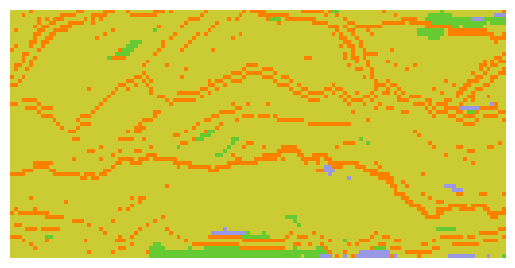

0.0


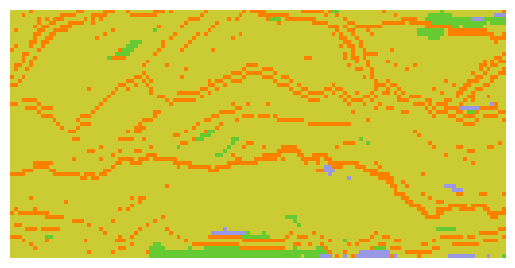

0.05263157894736842


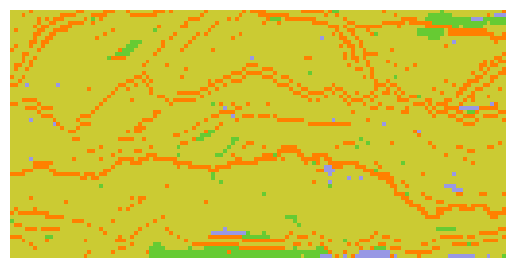

0.10526315789473684


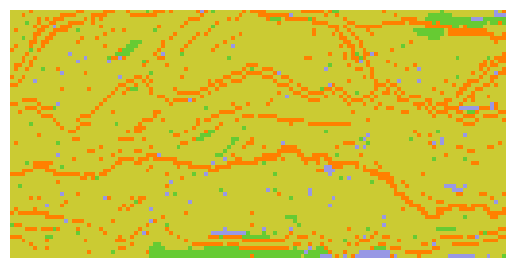

0.15789473684210525


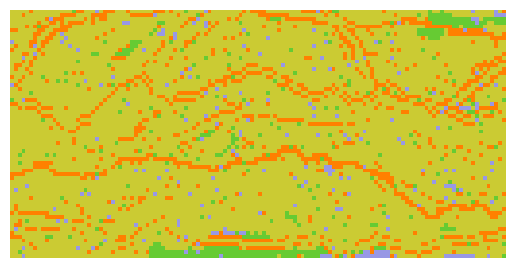

0.21052631578947367


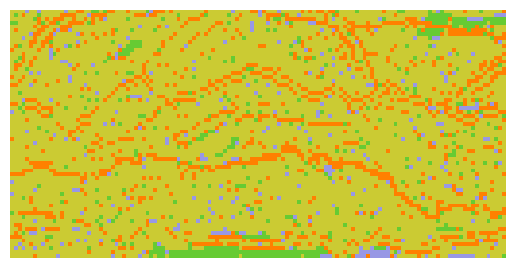

0.2631578947368421


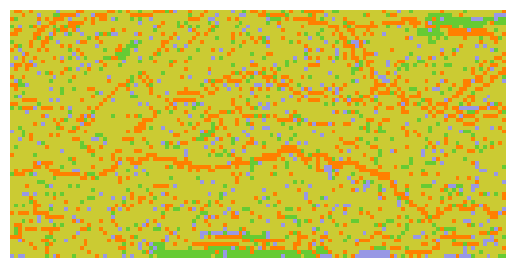

0.3157894736842105


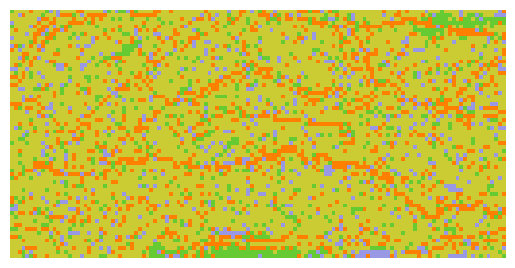

0.3684210526315789


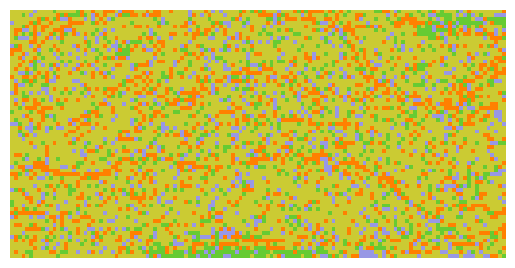

0.42105263157894735


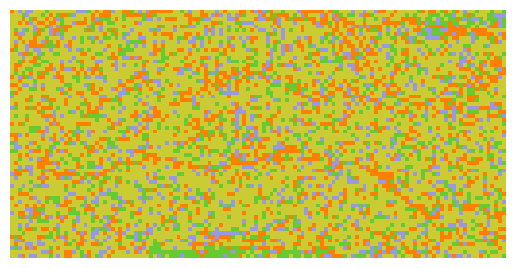

0.47368421052631576


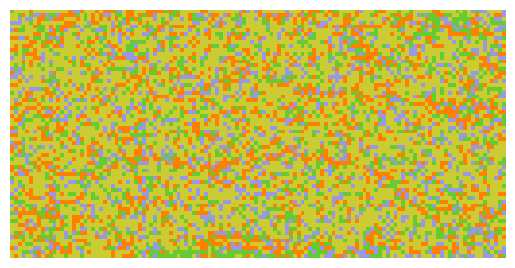

0.5263157894736842


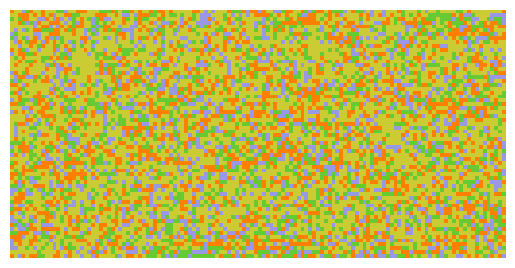

0.5789473684210527


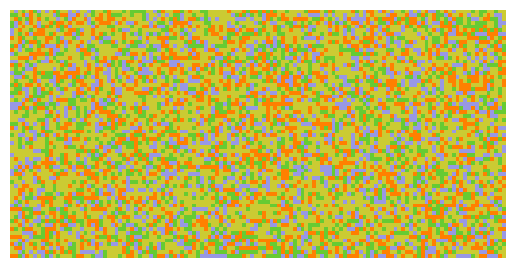

0.631578947368421


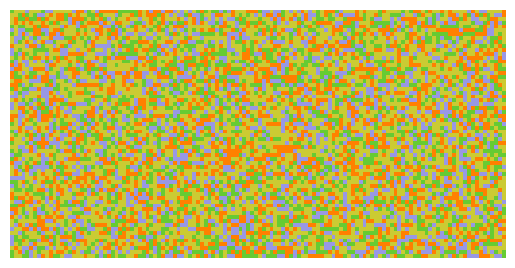

0.6842105263157894


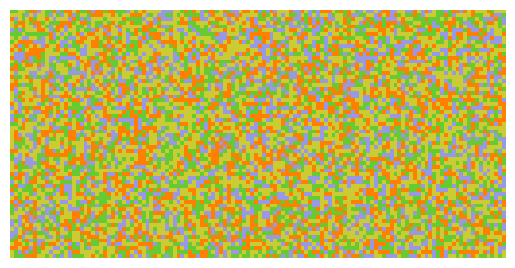

0.7368421052631579


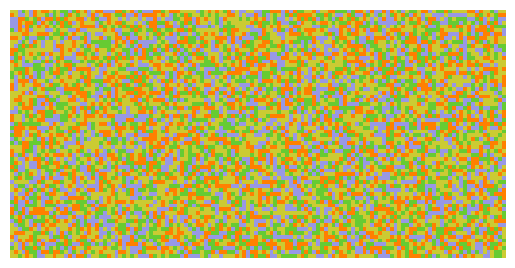

0.7894736842105263


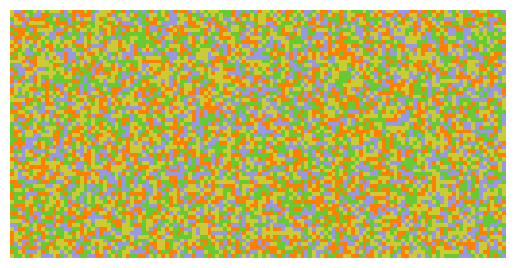

0.8421052631578947


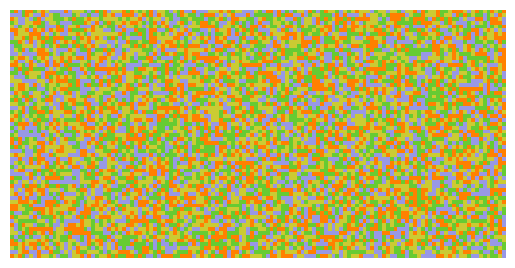

0.894736842105263


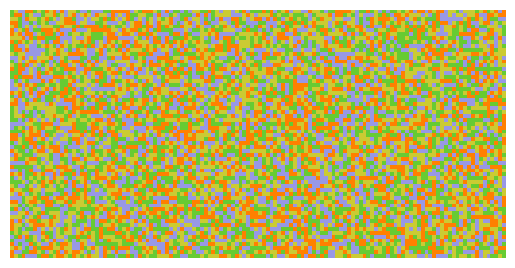

0.9473684210526315


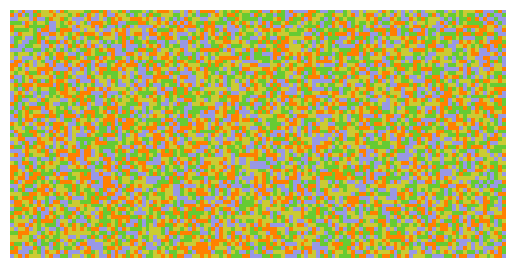

1.0


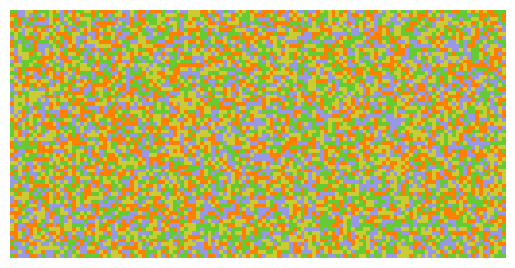

In [438]:
times= np.linspace(0, 1, num=20)
plt.axis('off')

plt.imshow(np.argmax(x_test[0], axis=-1).reshape((64, 128)),
            interpolation='nearest', cmap=cmap, norm=norm)
plt.show()
for t in times:
    xt, _ = forward_process(x_test[0], t, 4, np.pi*2)
    print(t)
    plt.axis('off')

    plt.imshow(np.argmax(xt.numpy(), axis=-1).reshape((64, 128)),
                interpolation='nearest', cmap=cmap, norm=norm)
    plt.show()

In [439]:
def compute_variance(pxt, values):
    v = np.sum(np.multiply(values ** 2, pxt)) - np.sum(np.multiply(values, pxt))**2
    return v

In [440]:
def schedule_test_forward_process(x0, t, nb_categories, period, type="cosine"):
    if len(x0.shape) != 3:
        raise Exception("Entry must have 3 dims but {0} were found".format(len(x0.shape)))
    Q_integral = make_qmatrix_integral(nb_categories, t, period, type=type)
    eQt = tf.linalg.expm(Q_integral)
    eQt = tf.cast(eQt, tf.float32)
    pxt = tf.tensordot(x0, eQt, axes=[2, 0])
    
    #print(pxt.shape)
    variance = pxt * (1 - pxt)
    #print(variance)
    #(pxt)
    
    height, width, _ = pxt.shape
    flat_pxt = tf.reshape(pxt, (-1, 4))
    cum_sum = tf.math.cumsum(flat_pxt, axis=-1)
    unif = np.random.rand(len(cum_sum), 1)
    random_values = tf.math.argmax((unif < cum_sum), axis=1)
    xt = tf.reshape(random_values, (height, width))
    xt = tf.one_hot(xt, nb_categories)
    return xt, pxt


In [441]:
pxt

<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=array([[[0.23847204, 0.28458387, 0.23847204, 0.23847204]]], dtype=float32)>

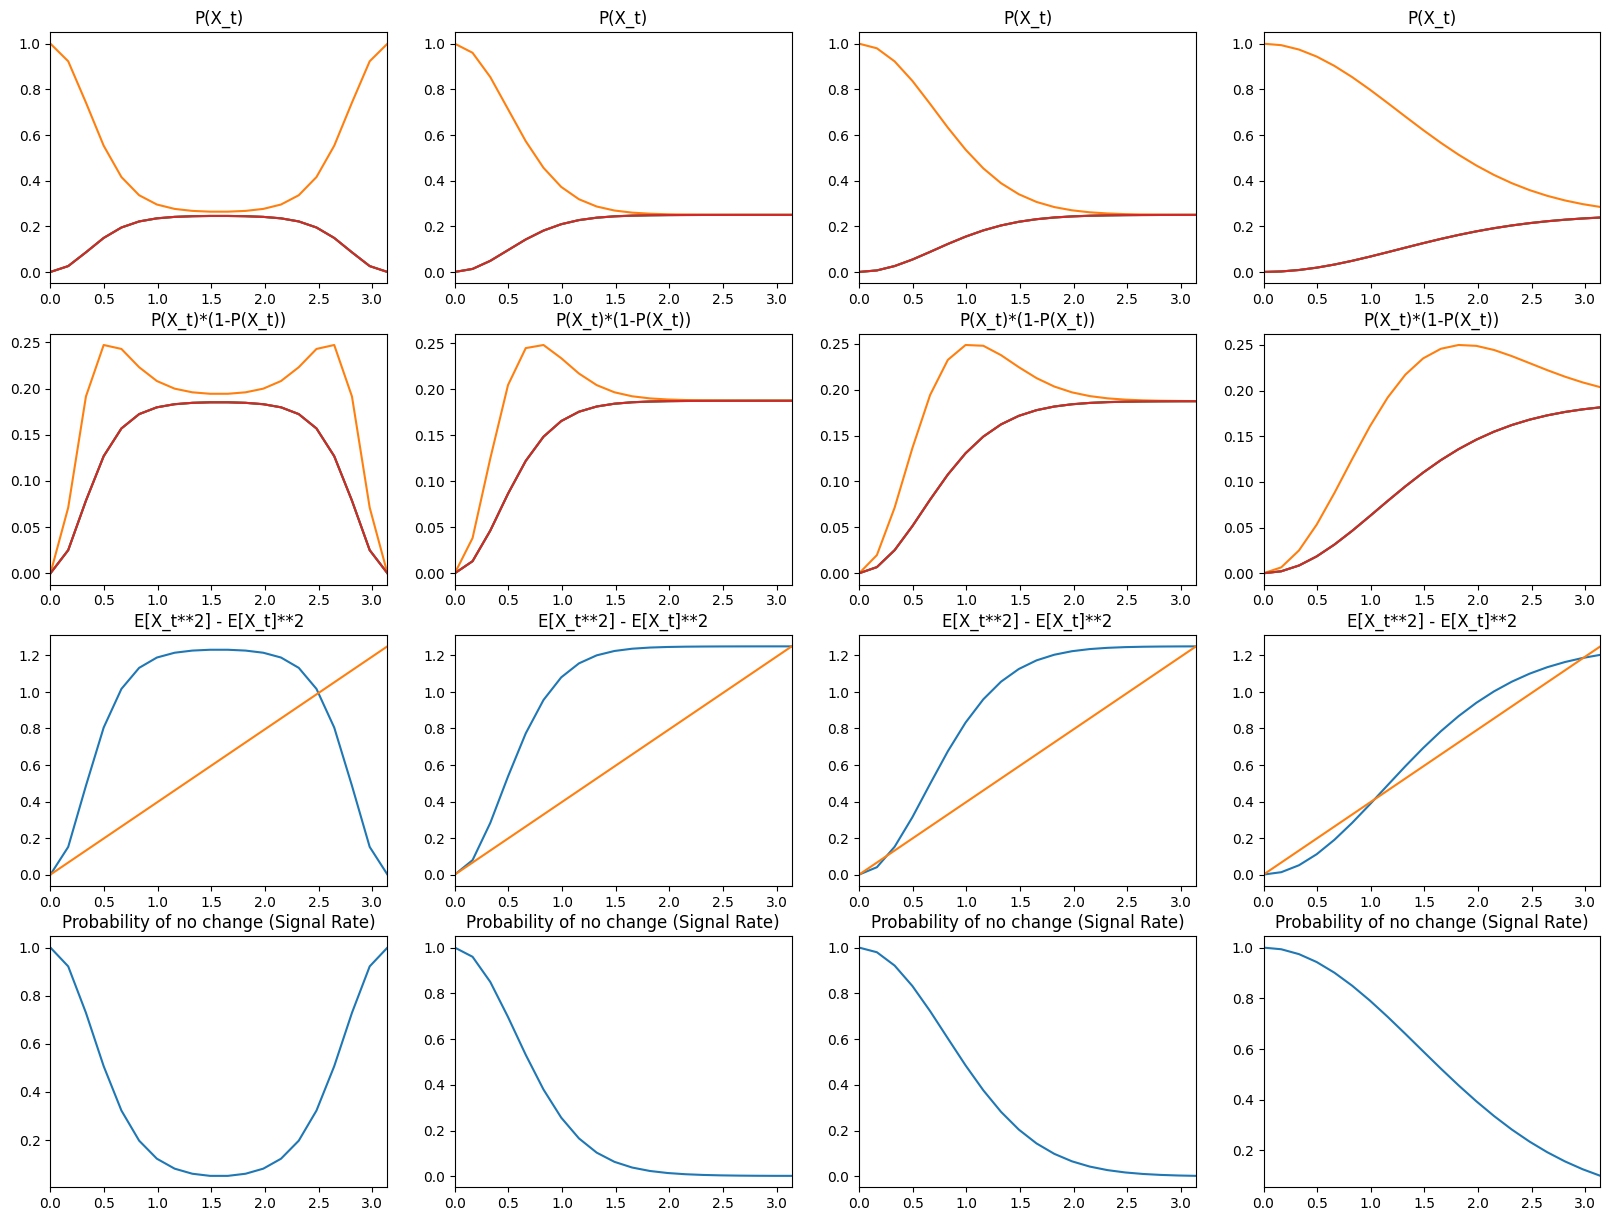

In [442]:
x0_pixel = tf.reshape(x_test[0][0, 0], (1, 1, -1))
max_t = np.pi
times= np.linspace(0, max_t, num=20)
linear= np.linspace(0, 1.25, num=20)
values = np.array([1, 2, 3, 4])
periods = [1/2, 1., 2., 2*np.pi]

fig = plt.figure(figsize=(20, 15))

for i, period in enumerate(periods):
    pxt_txts = []
    variances = []
    #probas_change = []
    qs = []
    
    for t in times:
        xt, pxt = schedule_test_forward_process(x0_pixel, t, 4, period, type="sine")
        #q = make_qmatrix(4, t, period)
        #print(np.sum(q[0, 1:]))
        #qs.append(np.sum(q[0, 1:])*np.exp(-np.sum(q[0, 1:])*1))
        
        q_int = make_qmatrix_integral(4, t, period, type="sine")
        qi = np.sum(q_int[0, 1:])
        prob_no_event = np.exp(-qi)
        qs.append(prob_no_event)
        
        
        pxt_txts.append(tf.squeeze(pxt))
        #proba_change = np.sum(pxt[:, :, 1:])
        variance = compute_variance(np.squeeze(pxt), values)
        variances.append(variance)
        #probas_change.append(proba_change)
        #print(t)

    #probas_change = np.array(probas_change)
    qs = np.array(qs)
    pxt_txts = np.array(pxt_txts)
    facies_variance = pxt_txts * (1 - pxt_txts)
    variances = np.array(variances)
    
    plt.subplot(4, len(periods), i + 1)
    plt.title("P(X_t)")
    plt.plot(times, pxt_txts)
    plt.xlim([0, max_t])

    plt.subplot(4, len(periods), i + 1 + len(periods))
    plt.title("P(X_t)*(1-P(X_t))")
    plt.plot(times, facies_variance)
    plt.xlim([0, max_t])

    plt.subplot(4, len(periods), i + 1 + len(periods) * 2)
    plt.title("E[X_t**2] - E[X_t]**2")
    plt.plot(times, variances)
    plt.plot(times, linear)
    plt.xlim([0, max_t])

    #plt.subplot(5, len(periods), i + 1 + len(periods) * 4)
    #plt.title("Different facies Probability")
    #plt.plot(times, probas_change)
    #plt.xlim([0, np.pi])

    plt.subplot(4, len(periods), i + 1 + len(periods) * 3)
    plt.title("Probability of no change (Signal Rate)")
    plt.plot(times, qs)
    plt.xlim([0, max_t])

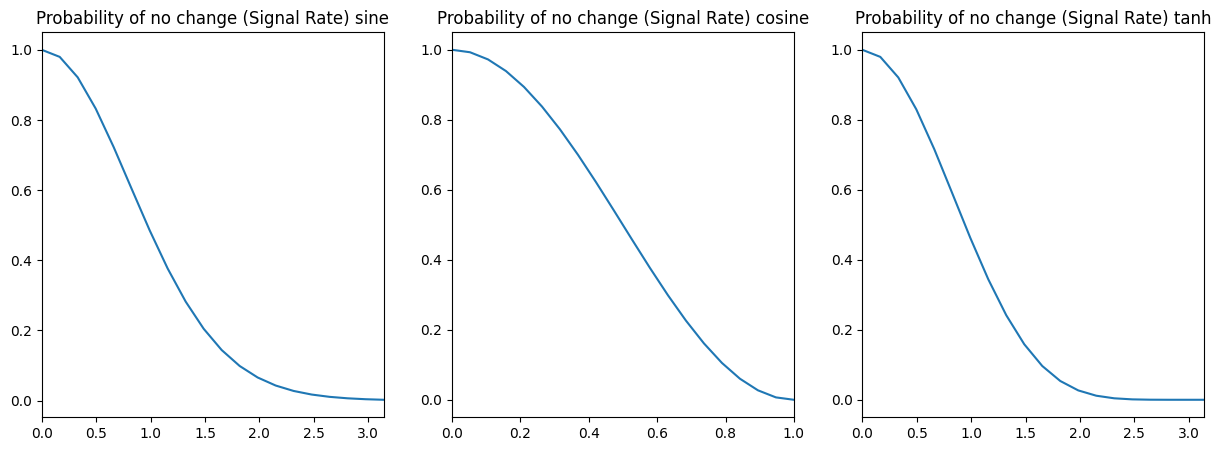

In [443]:
x0_pixel = tf.reshape(x_test[0][0, 0], (1, 1, -1))
max_t = [np.pi, 1, np.pi]

linear= np.linspace(0, 1.25, num=20)
values = np.array([1, 2, 3, 4])
period = 2
types = ["sine", "cosine", "tanh"]

fig = plt.figure(figsize=(15, 5))

for i, type in enumerate(types):
    qs = []
    times= np.linspace(0, max_t[i], num=20)
    for t in times:
        
        q_int = make_qmatrix_integral(4, t, period, type=type)
        qi = np.sum(q_int[0, 1:])
        prob_no_event = np.exp(-qi)
        qs.append(prob_no_event)
        

    #probas_change = np.array(probas_change)
    qs = np.array(qs)
    plt.subplot(1, 3, i+1)
    plt.title("Probability of no change (Signal Rate) {}".format(type))
    plt.plot(times, qs)
    plt.xlim([0, max_t[i]])

In [444]:
nb_categories=4
def apply_forward(xt, t):
    return forward_process(xt, t, nb_categories, np.pi*2)
    
modified_batch, _ = tf.map_fn(lambda x: apply_forward(x[0], x[1]), (x_test, input_diffusion_times))

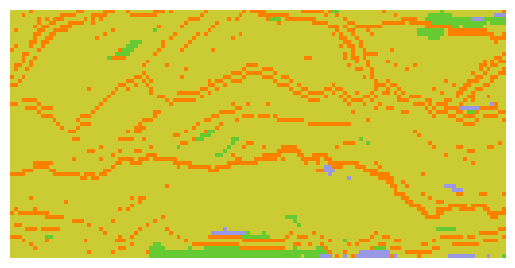

0.0


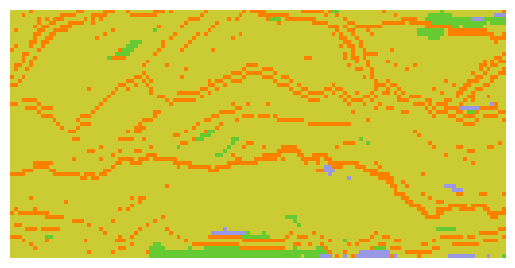

0.05263157894736842


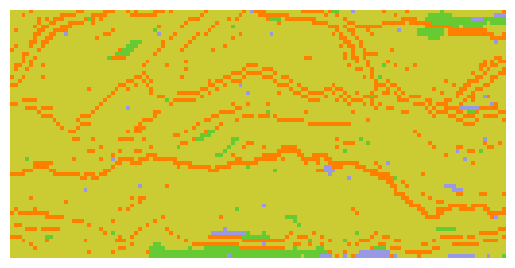

0.10526315789473684


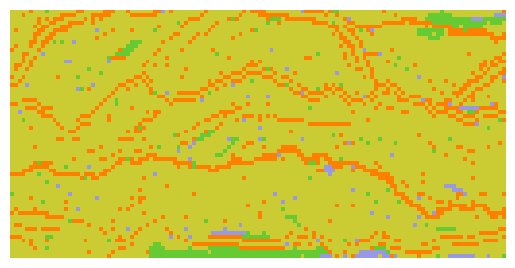

0.15789473684210525


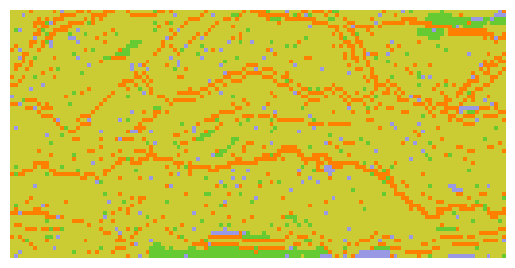

0.21052631578947367


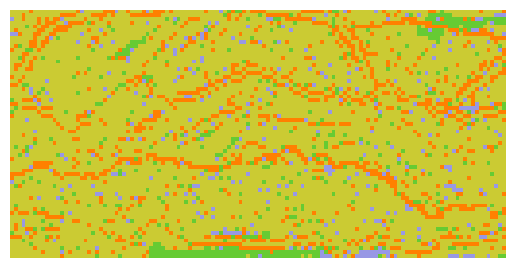

0.2631578947368421


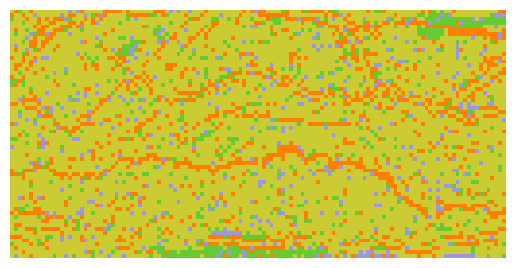

0.3157894736842105


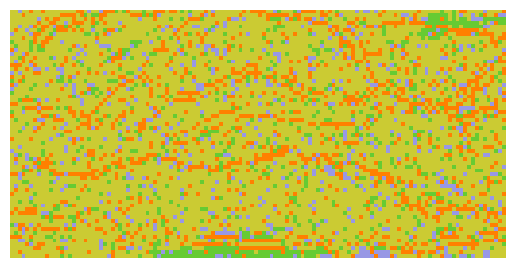

0.3684210526315789


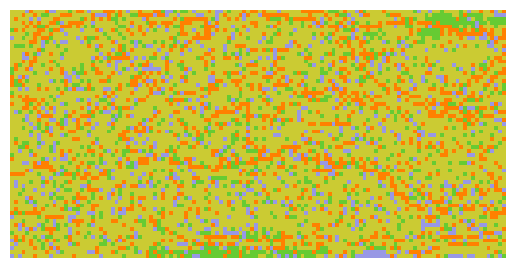

0.42105263157894735


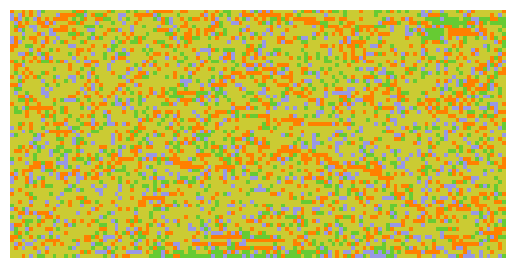

0.47368421052631576


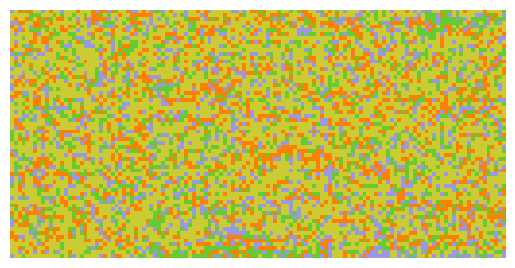

0.5263157894736842


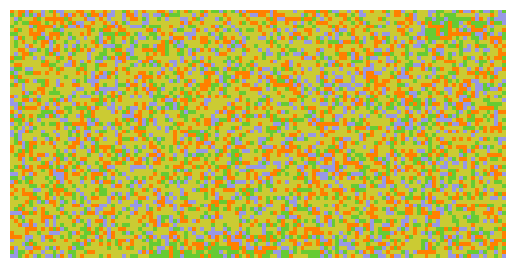

0.5789473684210527


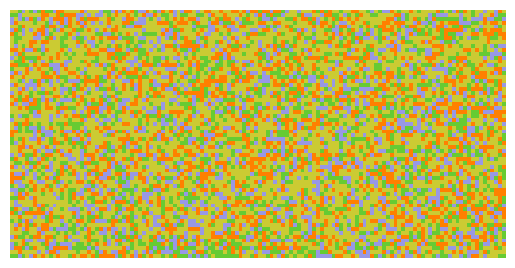

0.631578947368421


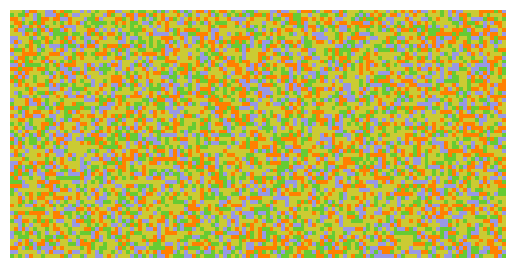

0.6842105263157894


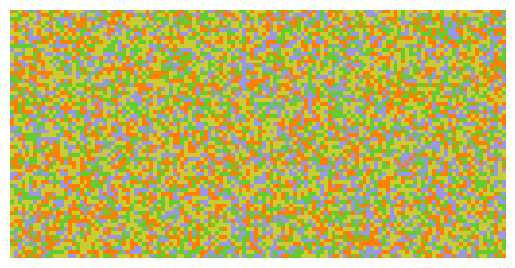

0.7368421052631579


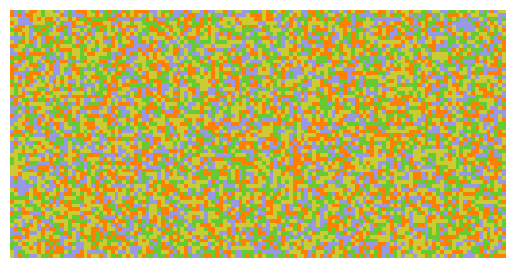

0.7894736842105263


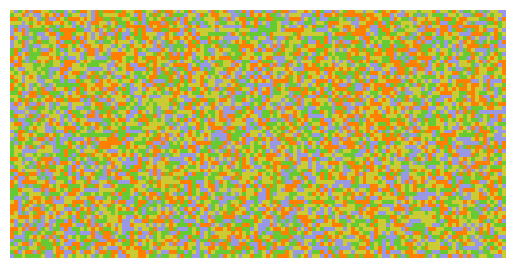

0.8421052631578947


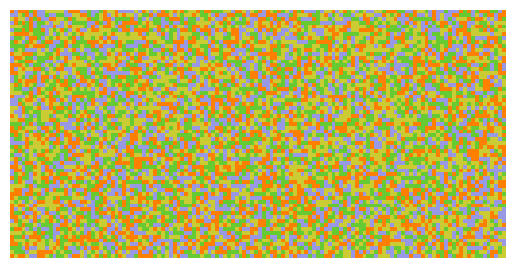

0.894736842105263


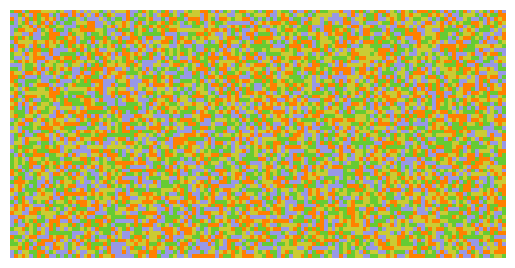

0.9473684210526315


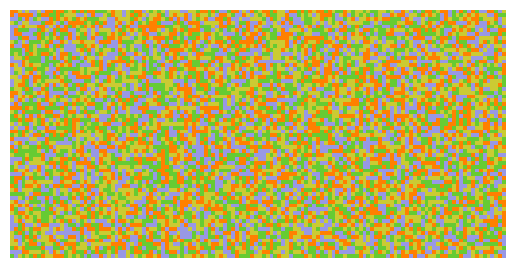

1.0


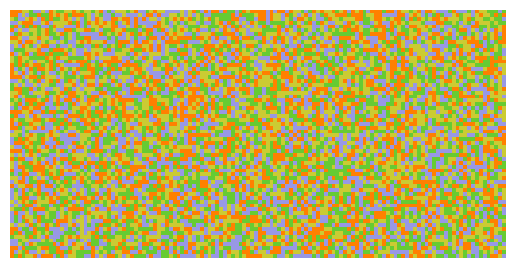

In [445]:
times= np.linspace(0, 1, num=20)
plt.axis('off')

plt.imshow(np.argmax(x_test[0], axis=-1).reshape((64, 128)),
            interpolation='nearest', cmap=cmap, norm=norm)
plt.show()
for t in times:
    print(t)
    xt, _ = forward_process(x_test[0], t, 4, np.pi*2)
    plt.axis('off')

    plt.imshow(np.argmax(xt.numpy(), axis=-1).reshape((64, 128)),
                interpolation='nearest', cmap=cmap, norm=norm)
    plt.show()

In [454]:
def reverse_pxtm1(x0, xt, t, tm1, nb_ctg, period, sample=False):
    Q_integral_t_tm1 = make_qmatrix_integral(nb_ctg, t, period, tm1)
    Q_integral_t_0 = make_qmatrix_integral(nb_ctg, t, period)
    Q_integral_tm1_0 = make_qmatrix_integral(nb_ctg, tm1, period)
    
    eQt_tm1 = tf.linalg.expm(Q_integral_t_tm1)
    eQt_tm1 = tf.cast(eQt_tm1, tf.float32)
    
    eQt_0 = tf.linalg.expm(Q_integral_t_0)
    eQt_0 = tf.cast(eQt_0, tf.float32)
    
    eQtm1_0 = tf.linalg.expm(Q_integral_tm1_0)
    eQtm1_0 = tf.cast(eQtm1_0, tf.float32)
    
    nom = tf.multiply(tf.tensordot(xt, eQt_tm1, axes=[2, 0]), tf.tensordot(x0, eQtm1_0, axes=[2, 0]))
    denom = tf.expand_dims(tf.reduce_sum(tf.multiply(tf.tensordot(x0, eQt_0, axes=[2, 0]), xt), axis=-1), axis=-1)
    pxt = nom / denom
    
    if sample:
        height, width, _ = pxt.shape
        flat_pxt = tf.reshape(pxt, (-1, 4))
        cum_sum = tf.math.cumsum(flat_pxt, axis=-1)
        unif = np.random.rand(len(cum_sum), 1)
        random_values = tf.math.argmax((unif < cum_sum), axis=1)
        pxt = tf.reshape(random_values, (height, width))
        pxt = tf.one_hot(pxt, nb_ctg)
        
    return  pxt , xt, t, tm1

## Hyperparameters

In [455]:
# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
widths = [32, 64, 128, 256]
block_depth = 2

# Data values embedding
img_embed_size = 64
categories_nb = 4

# optimization
batch_size = 30
ema = 0.999
learning_rate = 1e-4
embeding_net_lr = 1e-3
weight_decay = 1e-4

## Models

In [456]:
class GaussianFourierProjection(tf.keras.layers.Layer):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = self.add_weight(shape=(embed_dim // 2,),
                                 trainable=False,
                                 initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.), name="GFP") * tf.constant(scale, dtype=tf.float32)
    
    @tf.function
    def call(self, x):
        x_proj = x * self.W * tf.constant(2., dtype=tf.float32) * tf.constant(np.pi, dtype=tf.float32)
        y = tf.concat([tf.math.sin(x_proj), tf.cos(x_proj)], axis=-1)
        return y # Probleme vient pas de là :()

In [457]:
def get_network(
    image_size,
    noise_embedding_max_frequency,
    noise_embedding_dims,
    image_embedding_dims,
    block_depth,
    widths,
    attentions,
    patch_size,
    nb_categories
):
    def EmbeddingLayer(embedding_max_frequency, embedding_dims):
        def sinusoidal_embedding(x):
            embedding_min_frequency = 1.0
            frequencies = tf.exp(
                tf.linspace(
                    tf.math.log(embedding_min_frequency),
                    tf.math.log(embedding_max_frequency),
                    embedding_dims // 2,
                )
            )
            angular_speeds = 2.0 * math.pi * frequencies
            embeddings = tf.concat(
                [
                    tf.sin(angular_speeds * x),
                    tf.cos(angular_speeds * x),
                ],
                axis=3,
            )
            return embeddings

        def forward(x):
            x = layers.Lambda(sinusoidal_embedding)(x)
            return x

        return forward

    def ResidualBlock(width, attention):
        def forward(x):
            x, n = x
            input_width = x.shape[3]
            if input_width == width:
                residual = x
            else:
                residual = layers.Conv2D(width, kernel_size=1)(x)

            n = layers.Dense(width)(n)

            x = tfa.layers.GroupNormalization(groups=8)(x)
            x = keras.activations.swish(x)
            x = layers.Conv2D(width, kernel_size=3, padding="same")(x)

            x = layers.Add()([x, n])

            x = tfa.layers.GroupNormalization(groups=8)(x)
            x = keras.activations.swish(x)
            x = layers.Conv2D(width, kernel_size=3, padding="same")(x)

            x = layers.Add()([residual, x])

            if attention:
                residual = x
                x = tfa.layers.GroupNormalization(groups=8, center=False, scale=False)(
                    x
                )
                x = layers.MultiHeadAttention(
                    num_heads=4, key_dim=width, attention_axes=(1, 2)
                )(x, x)

                x = layers.Add()([residual, x])

            return x

        return forward

    def DownBlock(block_depth, width, attention):
        def forward(x):
            x, n, skips = x
            for _ in range(block_depth):
                x = ResidualBlock(width, attention)([x, n])
                skips.append(x)
            x = layers.AveragePooling2D(pool_size=2)(x)
            return x

        return forward

    def UpBlock(block_depth, width, attention):
        def forward(x):
            x, n, skips = x
            x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
            for _ in range(block_depth):
                x = layers.Concatenate()([x, skips.pop()])
                x = ResidualBlock(width, attention)([x, n])
            return x

        return forward

    images = keras.Input(shape=(None, None, nb_categories))
    diffusion_times = keras.Input(shape=(1, 1, 1))
    mask = keras.Input(shape=(None, None, 1))
    conditioning_pixels = keras.Input(shape=(None, None, nb_categories))

    x = tf.keras.layers.Concatenate(axis=-1)([images, mask, conditioning_pixels])

    x = layers.Conv2D(image_embedding_dims, kernel_size=patch_size, strides=patch_size)(
        x
    )

    # NOISE EMBEDDING
    n = EmbeddingLayer(noise_embedding_max_frequency, noise_embedding_dims)(
        diffusion_times
    )
    n = layers.Dense(noise_embedding_dims, activation=keras.activations.swish)(n)
    n = layers.Dense(noise_embedding_dims, activation=keras.activations.swish)(n)

    skips = []
    for width, attention in zip(widths[:-1], attentions[:-1]):
        x = DownBlock(block_depth, width, attention)([x, n, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1], attentions[-1])([x, n])

    for width, attention in zip(widths[-2::-1], attentions[-2::-1]):
        x = UpBlock(block_depth, width, attention)([x, n, skips])

    x = layers.Conv2DTranspose(
        nb_categories, kernel_size=patch_size, strides=patch_size, kernel_initializer="zeros", activation="softmax"
    )(x)

    return keras.Model([images, diffusion_times, mask, conditioning_pixels], x, name="residual_unet")

In [458]:
# sampling
def make_mask(image_to_condition):
    nb_conditioning_points = np.random.randint(low=1.0, high=image_to_condition.shape[0] * image_to_condition.shape[1])
    random_x_coordinates = np.random.choice(image_to_condition.shape[0], nb_conditioning_points)
    random_y_coordinates = np.random.choice(image_to_condition.shape[1], nb_conditioning_points)
    mask = np.zeros((image_to_condition.shape[0], image_to_condition.shape[1], 1))
    mask[random_x_coordinates, random_y_coordinates, :] = 1
    return mask

In [459]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth,
                 categories_nb, embedding_lr=1e-3, batch_size=30,
                 large_model=False):
        super().__init__()

        noise_embedding_max_frequency = 1000.0
        noise_embedding_dims = 64
        image_embedding_dims = 64
        block_depth = 2
        self.nb_categories = categories_nb
        self.period = np.pi * 2

        if large_model:
            widths = [64, 128, 256, 512]
            attentions = [False, False, True, True]
        else:
            widths = [64, 96, 128, 256]
            attentions = [False, False, False, False]
            
        patch_size = 1

        #self.diffusion_schedule = CosineSchedule(start_log_snr=3.0, end_log_snr=-10.0,)
        self.network = get_network(image_size, noise_embedding_max_frequency,
                                   noise_embedding_dims, image_embedding_dims,
                                   block_depth, widths, attentions, patch_size,
                                   categories_nb)
        
        self.ema_network = keras.models.clone_model(self.network)
        self.image_size = image_size
        self.batch_size = batch_size

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    def conditional_reverse_probability(self, x0, xt, t, tm1, sample=False):
        t = tf.squeeze(t)
        tm1 = tf.squeeze(tm1)
        
        return reverse_pxtm1(x0, xt, t, tm1, self.nb_categories, self.period, sample=sample)
    
    def apply_forward(self, xt, t):
        t = tf.squeeze(t)
        return forward_process(xt, t, self.nb_categories, self.period)

    @property
    def metrics(self):
        return [self.image_loss_tracker]

    def denoise(self, noisy_images, time, training, mask=None, pixels=None):
        # the exponential moving average weights are used at evaluation

        if mask is None or pixels is None:
            mask = tf.zeros((noisy_images.shape[0], noisy_images.shape[1], noisy_images.shape[2], 1))
            pixels = tf.zeros(noisy_images.shape)

        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_images = network([noisy_images, time, mask, pixels], training=training)

        return pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            input_diffusion_times = (tf.ones((num_images, 1, 1, 1)) * self.period / 2) - step * step_size

            pred_images = self.denoise(
                noisy_images, input_diffusion_times, training=True
            )
            for i in range(2):
                plt.imshow(np.argmax(pred_images[i].numpy(), axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
                plt.axis("off")
                plt.show()
            next_diffusion_times = input_diffusion_times - step_size
            next_noisy_images, _, _, _ = tf.map_fn(lambda x: self.conditional_reverse_probability(x[0], x[1], x[2], x[3], sample=True),
                                                   (pred_images, noisy_images, input_diffusion_times, next_diffusion_times))
            
            #next_diffusion_times = input_diffusion_times - step_size
            #next_noisy_images, _ = tf.map_fn(lambda x: self.apply_forward(x[0], x[1]), (pred_images, next_diffusion_times))
            #next_noisy_images = forward_process(pred_images, self.q_matrix, next_diffusion_times, self.nb_categories)


        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        init_x = tf.random.uniform((num_images, 64, 128), 0, 4, dtype=tf.dtypes.int32)
        init_x = keras.utils.to_categorical(init_x)
        generated_images = self.reverse_diffusion(init_x, diffusion_steps)
        #generated_images = self.denormalize(generated_images)
        return generated_images


    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(self.batch_size, 1, 1, 1), minval=0.0, maxval=1.
        )
        diffusion_times_tm1 = tf.clip_by_value(diffusion_times - tf.random.uniform(
            shape=(self.batch_size, 1, 1, 1), minval=1e-2, maxval=1.
        ), 0., 1. - 1e-2)

        #mask_uncondi = tf.zeros((self.batch_size // 2, images.shape[1], images.shape[2], 1))
        #mask_condi = tf.map_fn(make_mask, images[self.batch_size // 2:])
        #mask = tf.concat([mask_uncondi, mask_condi], axis=0)
        mask = None #tf.zeros((self.batch_size, images.shape[1], images.shape[2], 1))

        # mix the images with noises accordingly
        pixels = None #tf.math.multiply(images, mask)
        noisy_images, _ = tf.map_fn(lambda x: self.apply_forward(x[0], x[1]), (images, diffusion_times))

        pxt, _, _, _ = tf.map_fn(lambda x: self.conditional_reverse_probability(x[0], x[1], x[2], x[3]),
                                 (images, noisy_images, diffusion_times, diffusion_times_tm1))
        
        with tf.GradientTape() as tape:
            #noisy_images = signal_rates * embed_images + noise_rates * noises
            #noisy_images = tf.math.multiply(noisy_images, tf.math.abs(mask - 1))
            # train the network to separate noisy images to their components
            pred_images = self.denoise(
                noisy_images, diffusion_times, training=True, mask=mask, pixels=pixels
            )
            image_loss = self.loss(images, pred_images)  # training loss
            pred_pxt, _, _, _ = tf.map_fn(lambda x: self.conditional_reverse_probability(x[0], x[1], x[2], x[3]),
                                          (pred_images, noisy_images, diffusion_times, diffusion_times_tm1))
            posterior_loss = self.loss(pxt, pred_pxt)
            loss = posterior_loss
            
        gradients_model = tape.gradient(loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients_model, self.network.trainable_weights))

        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.
        )

        #mask_uncondi = tf.zeros((self.batch_size // 2, images.shape[1], images.shape[2], 1))
        #mask_condi = tf.map_fn(make_mask, images[self.batch_size // 2:])
        mask = None #tf.concat([mask_uncondi, mask_condi], axis=0)

        #std = marginal_prob_std(diffusion_times, sigma=sigma)
        pixels = None #tf.math.multiply(images, mask)

        noisy_images, _ = tf.map_fn(lambda x: self.apply_forward(x[0], x[1]), (images, diffusion_times))
        # noisy_images = forward_process(images, self.q_matrix, diffusion_times, self.nb_categories)
        #noisy_images = tf.math.multiply(noisy_images, tf.math.abs(mask - 1))
        #noisy_images = embed_images + noises * tf.reshape(std, (-1, 1, 1, 1))

        # use the network to separate noisy images to their components
        pred_images = self.denoise(
            noisy_images, diffusion_times, training=False, mask=mask, pixels=pixels
        )

        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)

        return {m.name: m.result() for m in self.metrics}

## Training

In [460]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth, categories_nb=categories_nb, large_model=True)

learning_rate = 1e-4


model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate
    ),
    loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
)

# run training and plot generated images periodically


In [461]:
t_epochs_nb=100

history = model.fit(x_train, batch_size=batch_size, epochs=t_epochs_nb, validation_data=(x_test,))

Epoch 1/100
92/92 [==============================] - 104s 934ms/step - i_loss: 0.9326 - val_i_loss: 1.3859
Epoch 2/100
92/92 [==============================] - 84s 910ms/step - i_loss: 1.0212 - val_i_loss: 1.3852
Epoch 3/100
92/92 [==============================] - 84s 912ms/step - i_loss: 1.1228 - val_i_loss: 1.3839
Epoch 4/100
92/92 [==============================] - 84s 913ms/step - i_loss: 1.1409 - val_i_loss: 1.3825
Epoch 5/100
92/92 [==============================] - 84s 913ms/step - i_loss: 1.1796 - val_i_loss: 1.3807
Epoch 6/100
92/92 [==============================] - 84s 913ms/step - i_loss: 1.1649 - val_i_loss: 1.3776
Epoch 7/100
92/92 [==============================] - 84s 912ms/step - i_loss: 1.1585 - val_i_loss: 1.3728
Epoch 8/100
92/92 [==============================] - 84s 911ms/step - i_loss: 1.1769 - val_i_loss: 1.3639
Epoch 9/100
92/92 [==============================] - 84s 913ms/step - i_loss: 1.1957 - val_i_loss: 1.3516
Epoch 10/100
92/92 [=========================

KeyboardInterrupt: 

## TESTS

In [ ]:
model.network.summary()

In [ ]:
x_axis = np.arange(t_epochs_nb)
plt.figure(figsize=(10, 5))
plt.plot(x_axis, history.history["i_loss"], label="Training image CE loss")
plt.plot(x_axis, history.history["val_i_loss"], label="Testing image CE loss")
plt.legend(loc="upper left")
plt.show()

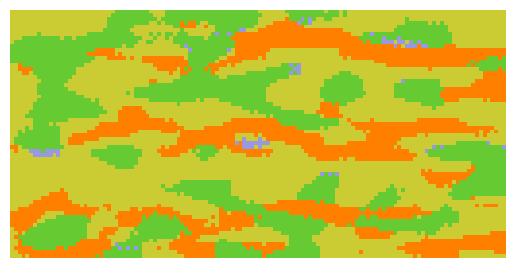

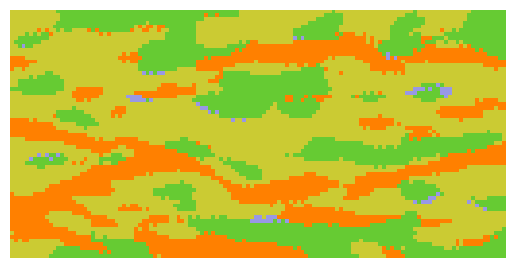

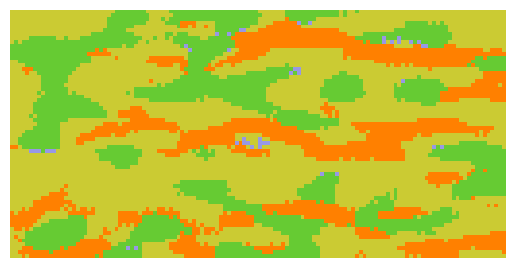

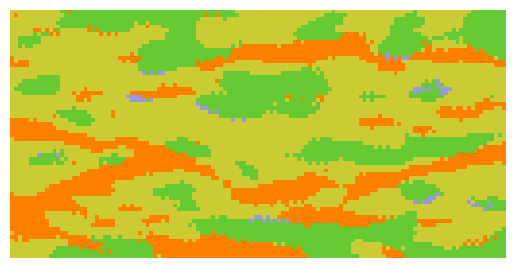

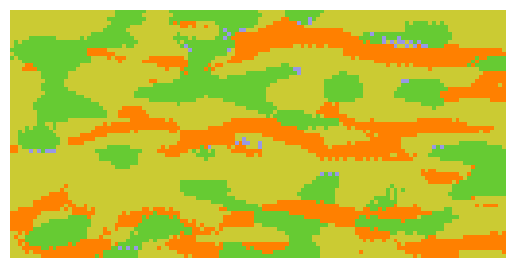

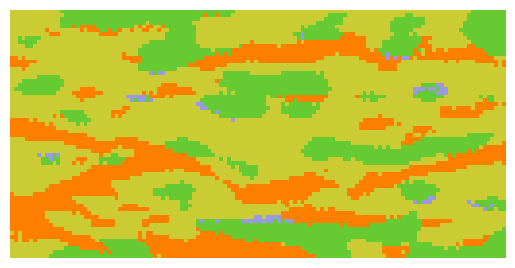

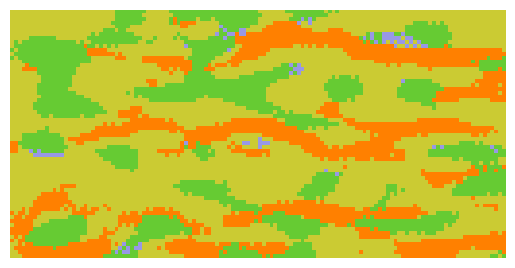

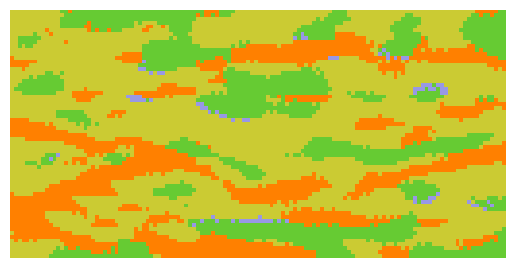

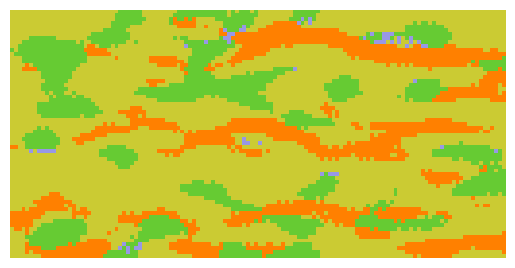

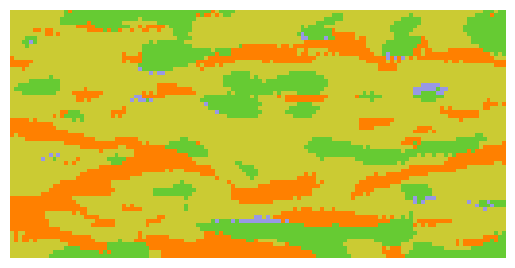

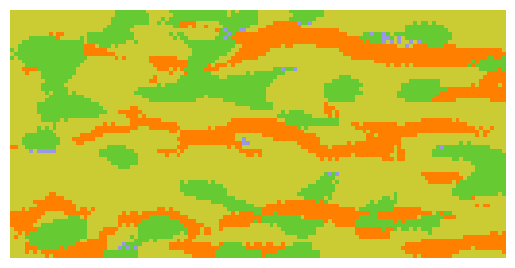

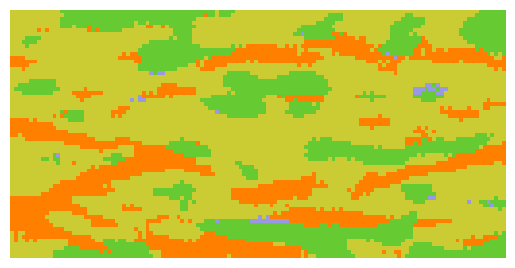

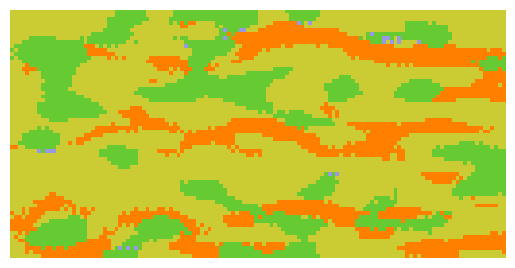

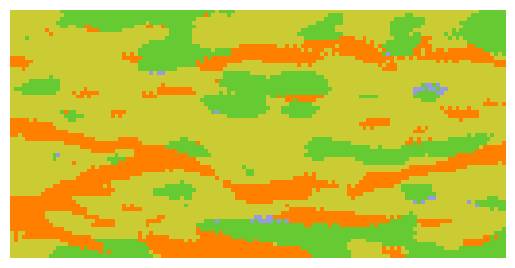

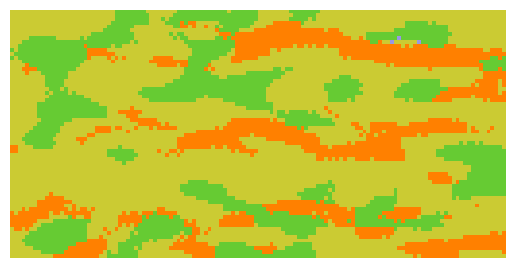

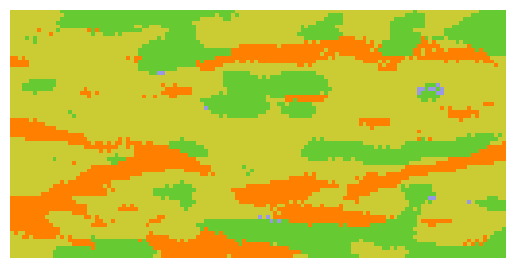

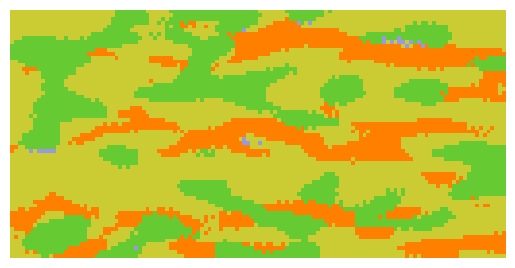

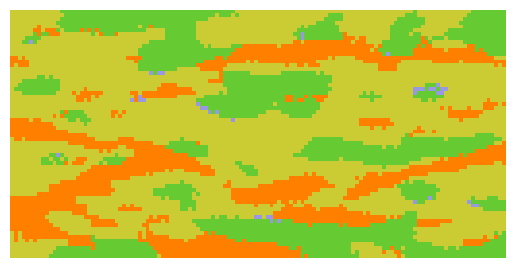

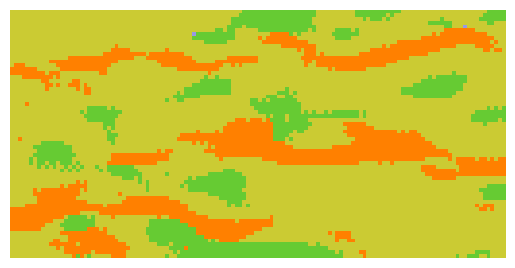

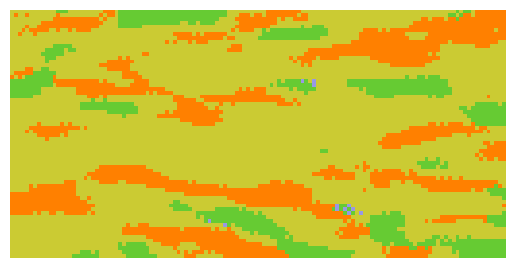

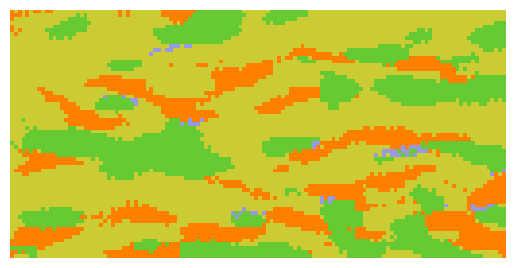

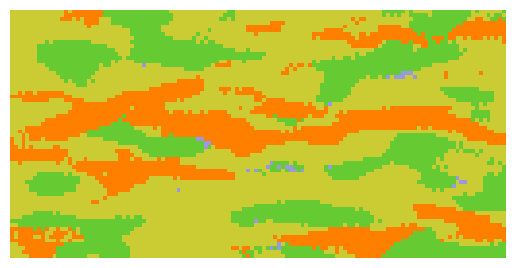

KeyboardInterrupt: 

In [462]:
x_generated = model.generate(10, 60)

In [ ]:
for i in range(10):
    plt.figure(figsize=(10, 5))
    plt.axis('off')

    plt.imshow(np.argmax(x_generated[i].numpy(), axis=-1).reshape((64, 128)),
                interpolation='nearest', cmap=cmap, norm=norm)
    plt.show()

## Inference

In [ ]:
import tqdm

In [ ]:
def second_order_correction(
    model,
    diffusion_times,
    step_size,
    noisy_images,
    signal_rates,
    noise_rates,
    pred_images,
    pred_noises,
    second_order_alpha,
    mask,
    pixels,
):
    # generic second-order Runge-Kutta method
    # https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods#Generic_second-order_method
    # based on https://arxiv.org/abs/2206.00364
    #batch_size=noisy_images.shape[0]
    #mask = tf.zeros((batch_size, image_size[0], image_size[1], 1))
    #pixels = tf.zeros((batch_size, image_size[0], image_size[1], img_embed_size))

    # use first estimate to sample alpha steps away
    alpha_signal_rates, alpha_noise_rates = model.diffusion_schedule(
        diffusion_times - second_order_alpha * step_size
    )
    alpha_noisy_images = (
        alpha_signal_rates * pred_images + alpha_noise_rates * pred_noises
    )
    x_input = tf.math.multiply(noisy_images, tf.math.abs(mask - 1))
    pred_x0, alpha_pred_noises = model.denoise(x_input, noise_rates, signal_rates, training=False, mask=mask, pixels=pixels)
    int_encoded_img = tf.argmax(pred_x0, axis=-1)
    embed_pred_x0 = model.embedding_layer(int_encoded_img)

    # linearly combine the two noise estimates
    pred_noises = (1.0 - 1.0 / (2.0 * second_order_alpha)) * pred_noises + 1.0 / (
        2.0 * second_order_alpha
        ) * alpha_pred_noises

    pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
    return pred_images, pred_noises

In [ ]:


def compute_beta(curr_alphas, prev_alphas):

    betas = 1 - (prev_alphas / curr_alphas)
    return betas

In [ ]:
from tensorflow.python import xla
def ddpm_sampler(model, img_embed_size, image_size, batch_size=10, num_steps=10, eps=1e-3, mask=None, pixels=None):
    second_order_alpha = 1.1
    # T and schedule
    t = tf.ones((batch_size, 1, 1, 1), dtype=tf.float32)
    noise_rates, signal_rates = model.diffusion_schedule(t)

    if mask is None:
        mask = tf.zeros((batch_size, image_size[0], image_size[1], 1), dtype=tf.float32)
        pixels = tf.zeros((batch_size, image_size[0], image_size[1], img_embed_size), dtype=tf.float32)
    else:
        
        pixels = tf.argmax(pixels, axis=-1)
        pixels = model.embedding_layer(pixels)
        pixels = tf.math.multiply(pixels, mask)

        mask = tf.repeat(mask, batch_size, axis=0)
        mask = tf.cast(mask,  dtype=tf.float32)
        pixels = tf.repeat(pixels, batch_size, axis=0)

    # Sample noise
    uniform_init_x = tf.random.uniform((batch_size, image_size[0], image_size[1]), 0, 4, dtype=tf.dtypes.int32)
    noises = tf.random.normal(shape=(batch_size, image_size[0], image_size[1], img_embed_size))
    init_x = signal_rates * model.embedding_layer(uniform_init_x) + noise_rates * noises

    # Keep track of the chain
    samples_list = []
    samples_list.append( tf.keras.backend.constant(keras.utils.to_categorical(uniform_init_x)))

    # Steps and other algorithmic variables
    time_steps = tf.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    prev_alphas = signal_rates**2

    # INFERENCE REVERSE LOOP
    for time_step in tqdm.tqdm(time_steps):
        batch_time_step = tf.ones((batch_size, 1, 1, 1), dtype=tf.float32) * time_step
        noise_rates, signal_rates = model.diffusion_schedule(batch_time_step)
        cur_alphas = signal_rates**2
        betas = compute_beta(cur_alphas, prev_alphas)

        # PREDICT IMAGE
        x_input = tf.math.multiply(x, tf.math.abs(mask - 1))
        pred_x0, pred_noise = model.denoise(x_input, noise_rates, signal_rates, training=False, mask=mask, pixels=pixels)
        int_encoded_img = tf.argmax(pred_x0, axis=-1)
        embed_pred_x0 = model.embedding_layer(int_encoded_img)

        # optional second order sampling
        if second_order_alpha is not None:
            embed_pred_x0, pred_noises = second_order_correction(
                model,
                batch_time_step,
                step_size,
                x,
                signal_rates,
                noise_rates,
                embed_pred_x0,
                pred_noise,
                second_order_alpha,
                mask,
                pixels,)

        mean_x0 = tf.math.sqrt(cur_alphas) * betas / (1 - prev_alphas) * embed_pred_x0
        mean_x = tf.math.sqrt(1 - betas) * (1 - cur_alphas) / (1 - prev_alphas) * x
        x = mean_x + mean_x0 + tf.reshape(tf.math.sqrt(betas), (-1, 1, 1, 1)) * tf.random.normal(x.shape)

        samples_list.append(pred_x0)
        prev_alphas = cur_alphas

    return pred_x0, samples_list

In [ ]:
from tensorflow.python import xla
def ddpm_solver(model, img_embed_size, image_size, batch_size=10, num_steps=200, eps=1e-3, mask=None, pixels=None):
    second_order_alpha = 1.1
    # T and schedule
    t = tf.ones((batch_size, 1, 1, 1), dtype=tf.float32)
    noise_rates, signal_rates = model.diffusion_schedule(t)

    if mask is None:
        mask = tf.zeros((batch_size, image_size[0], image_size[1], 1), dtype=tf.float32)
        pixels = tf.zeros((batch_size, image_size[0], image_size[1], img_embed_size), dtype=tf.float32)
    else:
        
        pixels = tf.argmax(pixels, axis=-1)
        pixels = model.embedding_layer(pixels)
        pixels = tf.math.multiply(pixels, mask)

        mask = tf.repeat(mask, batch_size, axis=0)
        mask = tf.cast(mask,  dtype=tf.float32)
        pixels = tf.repeat(pixels, batch_size, axis=0)

    # Sample noise
    uniform_init_x = tf.random.uniform((batch_size, image_size[0], image_size[1]), 0, 4, dtype=tf.dtypes.int32)
    noises = tf.random.normal(shape=(batch_size, image_size[0], image_size[1], img_embed_size))
    init_x = signal_rates * model.embedding_layer(uniform_init_x) + noise_rates * noises

    # Keep track of the chain
    samples_list = []
    samples_list.append( tf.keras.backend.constant(keras.utils.to_categorical(uniform_init_x)))

    # Steps and other algorithmic variables
    time_steps = tf.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    #prev_alphas = signal_rates**2
    prev_snr = compute_snr(signal_rates, noise_rates)
    prev_noise_rates, prev_signal_rates = noise_rates, signal_rates

    # INFERENCE REVERSE LOOP
    for time_step in tqdm.tqdm(time_steps):
        batch_time_step = tf.ones((batch_size, 1, 1, 1), dtype=tf.float32) * time_step
        noise_rates, signal_rates = model.diffusion_schedule(batch_time_step)
        #cur_alphas = signal_rates**2
        #betas = compute_beta(cur_alphas, prev_alphas)

        # PREDICT IMAGE
        x_input = tf.math.multiply(x, tf.math.abs(mask - 1))
        pred_x0, pred_noise = model.denoise(x_input, noise_rates, signal_rates, training=False, mask=mask, pixels=pixels)
        int_encoded_img = tf.argmax(pred_x0, axis=-1)
        embed_pred_x0 = model.embedding_layer(int_encoded_img)
        predicted_noise = x_input - embed_pred_x0

        snr = compute_snr(signal_rates, noise_rates)
        s_t = get_t_from_snr((snr + prev_snr) / 2)
        s_noise_rates, s_signal_rates = model.diffusion_schedule(s_t)



        u = s_signal_rates / prev_signal_rates * x - s_noise_rates * (tf.math.exp((snr - prev_snr) / 2) - 1) * predicted_noise

        # PREDICT IMAGE 2
        x_input = tf.math.multiply(u, tf.math.abs(mask - 1))
        pred_x0, pred_noise = model.denoise(x_input, s_signal_rates, s_noise_rates, training=False, mask=mask, pixels=pixels)
        int_encoded_img = tf.argmax(pred_x0, axis=-1)
        embed_pred_x0 = model.embedding_layer(int_encoded_img)
        predicted_noise = x_input - embed_pred_x0

        x = signal_rates / prev_signal_rates * x - noise_rates * (tf.math.exp((snr - prev_snr)) - 1) * predicted_noise

        # optional second order sampling
        #if second_order_alpha is not None:
        #    embed_pred_x0, pred_noises = second_order_correction(
        #        model,
        #        batch_time_step,
        #        step_size,
        #        x,
        #        signal_rates,
        #        noise_rates,
        #        embed_pred_x0,
        #        pred_noise,
        #        second_order_alpha,
        #        mask,
        #        pixels,)

        #mean_x0 = tf.math.sqrt(cur_alphas) * betas / (1 - prev_alphas) * embed_pred_x0
        #mean_x = tf.math.sqrt(1 - betas) * (1 - cur_alphas) / (1 - prev_alphas) * x
        #x = mean_x + mean_x0 + tf.reshape(tf.math.sqrt(betas), (-1, 1, 1, 1)) * tf.random.normal(x.shape)

        samples_list.append(pred_x0)
        #prev_alphas = cur_alphas
        prev_snr = snr
        prev_noise_rates, prev_signal_rates = noise_rates, signal_rates
    pred_x0, pred_noise = model.denoise(x, noise_rates, signal_rates, training=False, mask=mask, pixels=pixels)
    return pred_x0, samples_list

In [ ]:

#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.

sample_batch_size = 10 #@param {'type':'integer'}
sampler = ddpm_solver #@param ['ddpm_sampler', 'ddpm_solver'] {'type': 'raw'}


## Generate samples using the specified sampler.
samples, samples_list = sampler(model,
                                img_embed_size,
                                (64, 128),
                                sample_batch_size,
                                mask=None,
                                pixels=None)

In [ ]:
from data.load_data import ConditionalDataGenerator

# Load Data
slice_size = (64, 128, 4)
dataloader = ConditionalDataGenerator(x_test, 1, slice_size, wells=10, mode=3)
pixels, mask, ground_truth = dataloader.__getitem__(0)
print(pixels.shape, mask.shape, ground_truth.shape)

In [ ]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.

sample_batch_size = 10 #@param {'type':'integer'}
sampler = ddpm_sampler #@param ['ddpm_sampler', 'pc_sampler'] {'type': 'raw'}


## Generate samples using the specified sampler.
samples, samples_list = sampler(model,
                                img_embed_size,
                                (64, 128),
                                sample_batch_size,
                                mask=mask,
                                pixels=pixels)

In [ ]:
for i in range(sample_batch_size):
    plt.figure(figsize=(10, 5))
    plt.axis('off')

    plt.imshow(np.argmax(samples[i].numpy(), axis=-1).reshape((64, 128)),
                interpolation='nearest', cmap=cmap, norm=norm)
    plt.show()

In [ ]:
from tensorflow import keras
from utils.visualisation import *
from data.load_data import get_3d_flumy_data, load_data, ConditionalDataGenerator
from models.load_trained_models import load_msgen_horizontal, wgan_horizontal,\
    load_msnwgen_2d_gs_horizontal, load_wgan_gs_horizontal, load_mswgen_sn_3d_horizontal
from utils.utils import generate_noise, correct_percentage


In [ ]:
nb_simulations = 3
cmap, norm = get_color_map(number_of_categories=4)

print_conditioned_results(ground_truth, samples, mask, nb_simulations, cmap, norm)

In [ ]:
plt.figure(figsize=(10, 5))
plt.axis('off')

plt.imshow(np.argmax(ground_truth, axis=-1).reshape((64, 128)),
            interpolation='nearest', cmap=cmap, norm=norm)
plt.show()

In [ ]:

#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.

sample_batch_size = 10 #@param {'type':'integer'}
sampler = ddpm_sampler #@param ['ddpm_sampler', 'pc_sampler'] {'type': 'raw'}


## Generate samples using the specified sampler.
samples, samples_list = sampler(model,
                                img_embed_size,
                                (128, 256),
                                sample_batch_size,)

In [ ]:
for i in range(sample_batch_size):
    plt.figure(figsize=(10, 5))
    plt.axis('off')

    plt.imshow(np.argmax(samples[i].numpy(), axis=-1).reshape((128, 256)),
                interpolation='nearest', cmap=cmap, norm=norm)
    plt.show()

## GIF

In [ ]:
import imageio
images = []
for i, batch in enumerate(samples_list):
    figure = plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.title("Timestep {0:.3f}".format(1 - (i / 350)))
    plt.imshow(np.argmax(batch[0].numpy(), axis=-1).reshape((64, 128)),
                interpolation='nearest', cmap=cmap, norm=norm)
    plt.savefig('foo.png', bbox_inches='tight')
    images.append(imageio.imread('foo.png'))
    plt.show() #close(figure)
imageio.mimsave('/movie.gif', images)

## Saving Models

In [ ]:
import os

SAVE_AND_TAR_RESULTS_WEIGHTS = True

if SAVE_AND_TAR_RESULTS_WEIGHTS:
  diffusion_checkpoint_path = "diffusion_weights_horiz/cp-diffusion2d_net_horiz.ckpt"
  diffusion_checkpoint_dir = os.path.dirname(diffusion_checkpoint_path)

  model.ema_network.save_weights(diffusion_checkpoint_path)

  !tar -czvf diffusion_weights_horiz.tar.gz ./diffusion_weights_horiz

  diffusion_checkpoint_path = "diffusion_weights_horiz/cp-diffusion2d_embed_horiz.ckpt"
  diffusion_checkpoint_dir = os.path.dirname(diffusion_checkpoint_path)

  model.embedding_layer.save_weights(diffusion_checkpoint_path)

  !tar -czvf diffusion_weights_horiz.tar.gz ./diffusion_weights_horiz